# Pairs Trading Significance Tests

In this notebook, I take the groupings obtained by hierarchical clustering in notebook "commodities-correlations" and test these pairs for cointegration. This means, I want to test if a linear combination of instruments exhibits mean reversion, such that a portfolio $\Pi$ given below is stationary:

$$ \Pi = a_1 \times C_1 + a_2 \times C_2 + ... + a_i \times C_i $$

Where each of $C_i$ indicates the position value of front month future for one commodity, and each $a_i$ assigns a weight to one instrument. The resulting $\Pi$ has the following property:

$$ Var(\Pi) \sim \tau^{2H} $$

Where $\tau$ is the time separating two price measurements, and $H$, the so-called Hurst exponent, is less than 0.5. 

For instrument pairs that exhibit cointegration, I can build mean-reversion strategies on top of them. 

I choose not to test for stationarity in single-commodity price series because commodity prices do by default increase by the inflation rate. 

The analysis in this notebook is inspired by Ernest Chan's * Algorithmic Trading (Wiley, 2013) *

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import CubicSpline
#from IPython.display import Audio
#sound_file = './sound/beep-01a.wav'
%matplotlib notebook

<IPython.core.display.Javascript object>


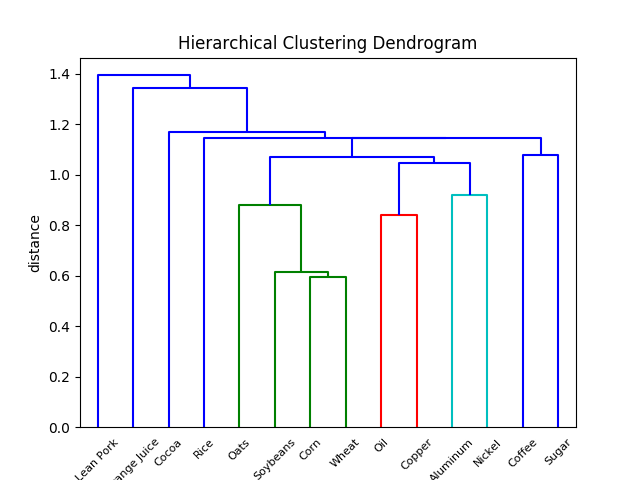

In [5]:
# Commodities
commodities_metadata = pd.read_csv('Commodities_metadata.csv')
commodities_data = pd.read_csv('Commodities_data.csv')

# Interpolate missing values
time_series_by_commodity = commodities_data.groupby(['Date', 'Ticker']).Open.mean().unstack()
# Drop butter, which is over 97% empty
time_series_by_commodity = time_series_by_commodity.drop(['BUT1_Comdty'], axis='columns')
# Linear interpolation for two seriously missing commodities
time_series_by_commodity[['LA1_Comdty', 'LN1_Comdty']] = time_series_by_commodity[['LA1_Comdty', 'LN1_Comdty']].interpolate()
# Cubic spline interpolation for other commodities
Y = time_series_by_commodity[['C_1_COMB_Comdty', 'CC1_COMB_Comdty', 'CL1_COMB_Comdty', 'HG1_COMB_Comdty', 'JO1_Comdty', 
                              'KC2_Comdty', 'LH1_COMB_Comdty', 'O_1_COMB_Comdty', 'RR1_COMB_Comdty', 'S_1_COMB_Comdty', 
                              'SB1_Comdty', 'W_1_COMB_Comdty']]
x = np.arange(len(Y))
time_series_by_commodity[['C_1_COMB_Comdty', 'CC1_COMB_Comdty', 'CL1_COMB_Comdty', 'HG1_COMB_Comdty', 'JO1_Comdty', 
                              'KC2_Comdty', 'LH1_COMB_Comdty', 'O_1_COMB_Comdty', 'RR1_COMB_Comdty', 'S_1_COMB_Comdty', 
                              'SB1_Comdty', 'W_1_COMB_Comdty']] \
= Y.apply(lambda y: CubicSpline(x[y.notnull()], y[y.notnull()])(x))
# Standardize to take prices on the first day as 1
time_series_by_commodity_std = time_series_by_commodity / time_series_by_commodity.iloc[0]

commodities_std_prices = time_series_by_commodity_std
commodities_log_returns = np.log(commodities_std_prices).diff()
commodities_log_returns = commodities_log_returns[1:]

from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(commodities_log_returns.corr(), 'single')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

def lookup(arr, df, keycol, targetcol):
    new_arr = []
    for e in arr:
        new_arr.append(df[df[keycol] == e].iloc[0][targetcol])
    return new_arr

dendrogram(
    Z,
    leaf_rotation=45.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    labels=lookup(commodities_log_returns.columns.values, commodities_metadata, 'Ticker', 'Commodity')
)
plt.show()

** From the dendrogram, we can find the following pairs/groups to test on: **

1. Oil and Copper
2. Aluminum and Nickel
3. Coffee and Sugar
4. Oats, Soybeans, Corn and Wheat

** These pairs all make economic sense - Oil and copper are staple industrial materials. Aluminum and Nickel are both important alloy components. Coffee and sugar are two very important tropical products, and the grains, in all of which USA is a major producer, should be heavily influenced by US agricultural yields. **

** Now, we plot these pairs to eye-ball if they do look cointegrating **

<IPython.core.display.Javascript object>


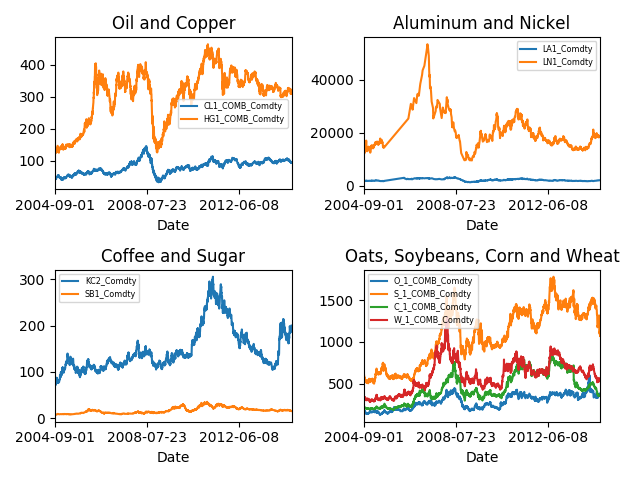

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2)
# Oil and Copper
oil_copper = time_series_by_commodity[['CL1_COMB_Comdty', 'HG1_COMB_Comdty']]
oil_copper.plot(title='Oil and Copper', ax=axes[0, 0])
axes[0, 0].legend(fontsize='xx-small')
# Aluminum and Nickel
alum_nick = time_series_by_commodity[['LA1_Comdty', 'LN1_Comdty']]
alum_nick.plot(title='Aluminum and Nickel', ax=axes[0, 1])
axes[0, 1].legend(fontsize='xx-small')
# Coffee and Sugar
coffee_sugar = time_series_by_commodity[['KC2_Comdty', 'SB1_Comdty']]
coffee_sugar.plot(title='Coffee and Sugar', ax=axes[1, 0])
axes[1, 0].legend(fontsize='xx-small')
# Oats, Soybeans, Corn and Wheat (grains)
grains = time_series_by_commodity[['O_1_COMB_Comdty', 'S_1_COMB_Comdty', 'C_1_COMB_Comdty', 'W_1_COMB_Comdty']]
grains.plot(title='Oats, Soybeans, Corn and Wheat', ax=axes[1, 1])
axes[1, 1].legend(fontsize='xx-small')
plt.tight_layout()
plt.show()

** Problem: For products that do not trade on the same price scale, it is hard to see the trend. Hence we standardize all prices to begin with 1 **

<IPython.core.display.Javascript object>


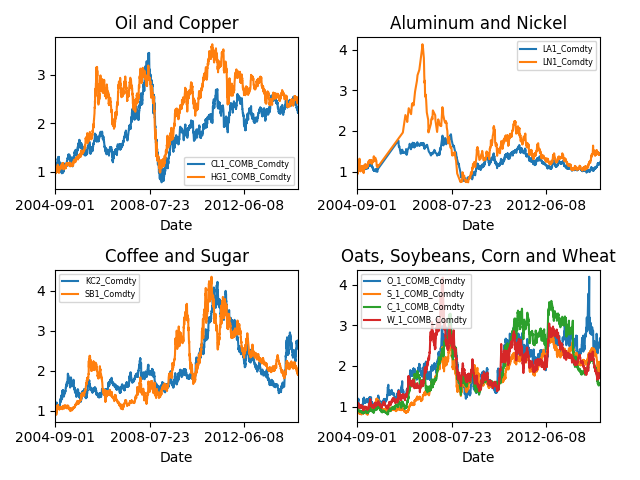

In [13]:
time_series_by_commodity_std = time_series_by_commodity / time_series_by_commodity.iloc[0]

fig, axes = plt.subplots(nrows=2, ncols=2)
# Oil and Copper
oil_copper = time_series_by_commodity_std[['CL1_COMB_Comdty', 'HG1_COMB_Comdty']]
oil_copper.plot(title='Oil and Copper', ax=axes[0, 0])
axes[0, 0].legend(fontsize='xx-small')
# Aluminum and Nickel
alum_nick = time_series_by_commodity_std[['LA1_Comdty', 'LN1_Comdty']]
alum_nick.plot(title='Aluminum and Nickel', ax=axes[0, 1])
axes[0, 1].legend(fontsize='xx-small')
# Coffee and Sugar
coffee_sugar = time_series_by_commodity_std[['KC2_Comdty', 'SB1_Comdty']]
coffee_sugar.plot(title='Coffee and Sugar', ax=axes[1, 0])
axes[1, 0].legend(fontsize='xx-small')
# Oats, Soybeans, Corn and Wheat (grains)
grains = time_series_by_commodity_std[['O_1_COMB_Comdty', 'S_1_COMB_Comdty', 'C_1_COMB_Comdty', 'W_1_COMB_Comdty']]
grains.plot(title='Oats, Soybeans, Corn and Wheat', ax=axes[1, 1])
axes[1, 1].legend(fontsize='xx-small')
plt.tight_layout()
plt.show()

** There seems to be a mean-reverting relationship between the differences of the four groups. Deserves a try ** 

** For this analysis, I use two kinds of tests. The first is called Cointegration Augmented Dickley-Fuller Test (ACDT), which tests if price level higher than the mean indicates a downward next move, and a price level lower than the mean indicate